In [ ]:
pip install --upgrade ultralytics

In [2]:
# Cuts the dataset into 5 folds (images only, no labels)
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from pathlib import Path

# Parameters: adjust these paths as needed
dataset_dir ="Road_Damage"
output_dir = "Road_Damage/folds"
n_splits = 5
random_state = 42
copy_files = True  # Set to False to use symlinks instead of copying

# Gather all samples and class labels
train_dir = Path(dataset_dir) / 'train'
test_dir = Path(dataset_dir) / 'test'
samples = []  # (img_path, class_name) - Removed label_path
class_names = []
for cls_dir in sorted(train_dir.iterdir()):
    if not cls_dir.is_dir():
        continue
    cls = cls_dir.name
    class_names.append(cls)
    for img_path in (cls_dir / 'images').glob('*.*'):
        samples.append((img_path, cls))  # Removed lbl_path

# Prepare arrays for stratification
image_paths = [s[0] for s in samples]
y = [class_names.index(s[1]) for s in samples]  # Changed index to use the class_name from the simplified samples

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
summary = {}

# Create folds
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(image_paths, y), start=1):
    fold_base = Path(output_dir) / f"fold_{fold_idx}"
    summary[fold_idx] = {'train': len(train_idx), 'val': len(val_idx), 'test': 0}

    # Train/val splits
    for split, idxs in [('train', train_idx), ('val', val_idx)]:
        for cls in class_names:
            (fold_base / split / cls / 'images').mkdir(parents=True, exist_ok=True)
        for i in idxs:
            img_src, cls_name = image_paths[i], samples[i][1]  # Removed lbl_src
            img_dst = fold_base / split / cls_name / 'images' / img_src.name
            if copy_files:
                shutil.copy(img_src, img_dst)
            else:
                os.symlink(img_src.resolve(), img_dst)

    # Copy test set unchanged
    if test_dir.exists():
        dst_test = fold_base / 'test'
        if dst_test.exists():
            shutil.rmtree(dst_test)
        shutil.copytree(test_dir, dst_test)
        test_images_dir = dst_test / 'images'
        summary[fold_idx]['test'] = len(list(test_images_dir.glob('*.*')))

# Print out summary to verify
print("K-fold generation summary:")
for fold, counts in summary.items():
    print(f"Fold {fold}: train={counts['train']}, val={counts['val']}, test={counts['test']}")

K-fold generation summary:
Fold 1: train=695, val=174, test=0
Fold 2: train=695, val=174, test=0
Fold 3: train=695, val=174, test=0
Fold 4: train=695, val=174, test=0
Fold 5: train=696, val=173, test=0


In [6]:
#Train 5 folds
import os
import gc
import torch
from ultralytics import YOLO

# ---------------- CONFIG ----------------
BASE_DIR = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds" 
MODEL_FILE = r"models\yolo11n-cls.pt"
FOLDS = 5
EPOCHS = 100
IMGSZ = 640
BATCH = 16  
PATIENCE = 25  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MEM_FRACTION = 0.6 
# ----------------------------------------

print(f"Using device: {DEVICE}\n")

if DEVICE == "cuda":
    torch.cuda.set_per_process_memory_fraction(MEM_FRACTION, device=0)

for fold in range(1, FOLDS + 1):
    gc.collect()
    torch.cuda.empty_cache()

    fold_dir = os.path.join(BASE_DIR, f"fold_{fold}")
    if not os.path.isdir(os.path.join(fold_dir, 'train')):
        raise FileNotFoundError(f"{fold_dir}/train not found")

    print(f"\n=== Training Fold {fold}/{FOLDS} on folder {fold_dir} ===")
    model = YOLO(MODEL_FILE)
    model.train(
        data=fold_dir,
        task='classify',
        epochs=EPOCHS,
        imgsz=IMGSZ,
        batch=BATCH,
        patience=PATIENCE,
        device=DEVICE,
        project=fold_dir,
        name='results',
    )

    print(f"--- Fold {fold} complete. Best weights in {fold_dir}/results ---")


Using device: cuda


=== Training Fold 1/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1 ===
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.0

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\train... 695 images, 0 corrupt: 100%|██████████| 695/695 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.1 ms, read: 294.045.3 MB/s, size: 186.9 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\val... 174 images, 0 corrupt: 100%|██████████| 174/174 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results3
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100       1.7G      1.112          7        640: 100%|██████████| 44/44 [00:05<00:00,  7.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all      0.828          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.94G     0.3896          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.69it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.94G     0.3184          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.09it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.94G     0.2546          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.88it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.94G     0.1885          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.42it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.94G     0.2253          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.29it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.94G      0.235          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.99it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.94G     0.2047          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.96it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.94G     0.2389          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.82it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.94G     0.1423          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.90it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.94G     0.1867          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.84it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.94G     0.1444          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.49it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.94G     0.1203          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.47it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.94G     0.1117          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.11it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.94G    0.08632          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.18it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.94G     0.1223          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.61it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.94G     0.1536          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.50it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.94G      0.126          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.27it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.94G    0.08381          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.62it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.94G    0.08839          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.49it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.94G    0.09583          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.17it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.94G    0.07716          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.79it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.94G    0.07535          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.90it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.94G    0.05964          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.37it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.94G    0.06243          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.54it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.94G    0.08078          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.02it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.94G    0.06438          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.46it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.94G    0.05695          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.66it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.94G    0.05919          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.42it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.94G    0.06352          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.68it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.94G    0.06562          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.39it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.94G    0.05304          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.65it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.94G    0.04376          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.81it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.94G    0.07889          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.61it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.94G     0.0704          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.23it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.94G    0.05944          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.04it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.94G    0.05199          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.23it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.94G     0.0514          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.61it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.94G    0.03863          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.56it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.94G    0.05625          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.33it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.94G    0.03484          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.17it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.94G    0.03542          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.77it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.94G    0.02507          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.57it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.94G    0.05954          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.00it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.94G    0.02039          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.76it/s]

                   all      0.954          1
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



45 epochs completed in 0.053 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results3\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results3\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results3\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\train... found 695 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\val... found 174 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\test... found 43 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 12.88it/s]


                   all      0.989          1
Speed: 0.5ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results3
--- Fold 1 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1/results ---

=== Training Fold 2/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2 ===
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2, degrees=0.0, deterministic=True, device=0, 

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\train... 695 images, 0 corrupt: 100%|██████████| 695/695 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 299.9110.1 MB/s, size: 158.5 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\val... 174 images, 0 corrupt: 100%|██████████| 174/174 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results2
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.71G      1.111          7        640: 100%|██████████| 44/44 [00:05<00:00,  8.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.96G     0.3976          7        640: 100%|██████████| 44/44 [00:04<00:00, 10.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.56it/s]

                   all      0.891          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.96G     0.2802          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.97it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.96G     0.2663          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.11it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.96G     0.2249          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.63it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.96G     0.2344          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.30it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.96G     0.1878          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.62it/s]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.96G     0.1925          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.25it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.96G     0.1835          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.48it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.96G      0.143          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.18it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.96G     0.1511          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.56it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.96G      0.153          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.94it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.96G     0.1658          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.97it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.96G     0.1207          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.67it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.96G     0.1065          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.75it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.96G    0.09807          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.19it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.96G     0.0931          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.53it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.96G     0.1021          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.29it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.96G    0.09904          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 22.13it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.96G    0.06831          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.57it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.96G     0.1279          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.27it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.96G    0.08984          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.00it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.96G    0.06183          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.75it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.96G    0.08791          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.62it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.96G    0.08044          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.71it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.96G     0.0583          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.10it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.96G    0.07469          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.71it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.96G    0.06012          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.64it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.96G     0.0447          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.87it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.96G    0.07188          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.18it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.96G     0.0705          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.77it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.96G    0.08404          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.99it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.96G     0.0551          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.69it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.96G    0.06163          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.62it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.96G    0.03236          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.56it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.96G    0.03232          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.98it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.96G    0.03825          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.90it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.96G    0.04161          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.07it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.96G    0.06067          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.67it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.96G    0.05698          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.16it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.96G    0.04658          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.89it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.96G     0.0269          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.83it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.96G    0.03656          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.48it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.96G    0.05431          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.68it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.96G    0.05628          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.14it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100      1.96G    0.04542          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.26it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.96G     0.0433          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.26it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.96G    0.04052          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.52it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.96G    0.02902          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.28it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      1.96G     0.0218          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.35it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      1.96G    0.02546          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.15it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      1.96G      0.031          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.11it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      1.96G    0.02715          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.06it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      1.96G    0.04621          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.41it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      1.96G    0.02468          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.27it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      1.96G    0.02728          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.17it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      1.96G     0.0159          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.91it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100      1.96G    0.01642          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.38it/s]

                   all      0.989          1
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 33, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



58 epochs completed in 0.068 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results2\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results2\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results2\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\train... found 695 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\val... found 174 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\test... found 43 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 12.10it/s]


                   all      0.994          1
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results2
--- Fold 2 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2/results ---

=== Training Fold 3/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3 ===
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3, degrees=0.0, deterministic=True, device=0, 

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\train... 695 images, 0 corrupt: 100%|██████████| 695/695 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 310.382.8 MB/s, size: 204.4 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\val... 174 images, 0 corrupt: 100%|██████████| 174/174 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results2
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.89G      1.114          7        640: 100%|██████████| 44/44 [00:10<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 15.85it/s]

                   all      0.839          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      2.13G     0.4016          7        640: 100%|██████████| 44/44 [00:04<00:00, 10.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.49it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      2.14G     0.2896          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.82it/s]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      2.14G     0.2636          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.86it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      2.14G     0.2187          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 23.14it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      2.14G     0.2303          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.16it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      2.14G     0.2181          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.97it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      2.14G     0.2003          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.32it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      2.14G     0.1925          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.61it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      2.14G     0.1694          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.82it/s]


                   all      0.966          1

      Epoch    GPU_mem       loss  Instances       Size


     11/100      2.14G     0.1706          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.76it/s]

                   all      0.891          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      2.14G     0.1926          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.64it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      2.14G     0.1563          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.97it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      2.14G     0.1401          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.14it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      2.14G    0.07857          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.10it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      2.14G    0.09385          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 22.14it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      2.14G     0.1091          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.67it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      2.14G     0.0701          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.52it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      2.14G     0.1127          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.24it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      2.14G    0.08098          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.67it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      2.14G     0.1013          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.24it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      2.14G     0.1027          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.70it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      2.14G    0.07943          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.69it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      2.14G    0.07861          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.30it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      2.14G    0.08162          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.00it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      2.14G    0.05994          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.19it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      2.14G    0.06697          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.95it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      2.14G    0.05307          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.14it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      2.14G     0.0497          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.89it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      2.14G    0.06176          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.87it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      2.14G    0.06013          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.18it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      2.14G    0.04484          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.69it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      2.14G    0.05005          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.78it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      2.14G    0.07195          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.01it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      2.14G    0.06117          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.97it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      2.14G    0.05391          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.86it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      2.14G    0.07588          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.93it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      2.14G    0.07418          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.32it/s]

                   all      0.989          1
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 13, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



38 epochs completed in 0.046 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results2\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results2\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results2\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\train... found 695 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\val... found 174 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\test... found 43 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 11.98it/s]


                   all          1          1
Speed: 0.5ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results2
--- Fold 3 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3/results ---

=== Training Fold 4/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4 ===
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4, degrees=0.0, deterministic=True, device=0, 

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\train... 695 images, 0 corrupt: 100%|██████████| 695/695 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 255.027.3 MB/s, size: 187.3 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\val... 174 images, 0 corrupt: 100%|██████████| 174/174 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.81G       1.11          7        640: 100%|██████████| 44/44 [00:05<00:00,  7.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      2.05G       0.38          7        640: 100%|██████████| 44/44 [00:04<00:00, 10.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.26it/s]

                   all      0.902          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      2.05G     0.2863          7        640: 100%|██████████| 44/44 [00:04<00:00, 10.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.69it/s]

                   all      0.868          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      2.05G     0.2666          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.20it/s]

                   all      0.851          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      2.05G     0.2655          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.89it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      2.05G     0.2258          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.43it/s]

                   all      0.851          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      2.05G      0.202          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.85it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      2.05G     0.2342          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.17it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      2.05G     0.2121          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.23it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      2.05G     0.1103          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.09it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      2.05G     0.1407          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.17it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      2.05G     0.1416          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.80it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      2.05G     0.1299          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.84it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      2.05G      0.119          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.72it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      2.05G     0.1413          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.85it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      2.05G    0.09455          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.32it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      2.05G    0.09972          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.86it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      2.05G     0.1493          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.08it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      2.05G    0.08513          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.31it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      2.05G    0.08747          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.51it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      2.05G     0.1093          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.14it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      2.05G    0.07612          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.59it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      2.05G     0.1201          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.00it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      2.05G     0.1094          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.26it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      2.05G    0.08291          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.18it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      2.05G    0.06472          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.76it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      2.05G    0.07182          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.20it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      2.05G    0.05922          7        640: 100%|██████████| 44/44 [00:03<00:00, 13.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.41it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      2.05G    0.08745          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.28it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      2.05G    0.05555          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.99it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      2.05G    0.04172          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 17.05it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      2.05G    0.02427          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.66it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      2.05G    0.02955          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.80it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      2.05G    0.04212          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.52it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      2.05G    0.05375          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.62it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      2.05G     0.0639          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.60it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      2.05G    0.02721          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.92it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      2.05G    0.04147          7        640: 100%|██████████| 44/44 [00:03<00:00, 11.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.61it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      2.05G     0.0259          7        640: 100%|██████████| 44/44 [00:03<00:00, 12.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.86it/s]

                   all      0.983          1
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



39 epochs completed in 0.048 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\train... found 695 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\val... found 174 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\test... found 43 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 11.03it/s]


                   all      0.989          1
Speed: 0.6ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2
--- Fold 4 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4/results ---

=== Training Fold 5/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5 ===
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5, degrees=0.0, deterministic=True, device=0, 

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\train... 696 images, 0 corrupt: 100%|██████████| 696/696 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 363.871.6 MB/s, size: 204.5 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\val... 173 images, 0 corrupt: 100%|██████████| 173/173 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results2
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.81G      1.097          8        640: 100%|██████████| 44/44 [00:05<00:00,  8.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all      0.832          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      2.05G     0.4108          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.32it/s]

                   all      0.879          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      2.05G     0.2973          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.42it/s]

                   all      0.844          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      2.05G     0.2974          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.19it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      2.05G     0.2748          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.52it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      2.05G     0.2211          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.76it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      2.05G     0.1831          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.27it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      2.05G     0.1962          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.88it/s]

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      2.05G     0.2388          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.06it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      2.05G     0.1372          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.77it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      2.05G     0.1167          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.82it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      2.05G     0.1488          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.17it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      2.05G     0.1324          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.00it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      2.05G     0.1391          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.49it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      2.05G     0.1383          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.62it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      2.05G    0.08014          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.80it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      2.05G    0.07328          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.22it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      2.05G    0.07883          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.47it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      2.05G     0.1127          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.09it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      2.05G     0.1141          8        640: 100%|██████████| 44/44 [00:04<00:00,  9.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 15.22it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      2.05G     0.1131          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.41it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      2.05G     0.1252          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.74it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      2.05G    0.07321          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.68it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      2.05G    0.07484          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.30it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      2.05G    0.06221          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.92it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      2.05G    0.06526          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.36it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      2.05G    0.07735          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.13it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      2.05G    0.07357          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.74it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      2.05G    0.07297          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      2.05G      0.045          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.19it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      2.05G    0.06846          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.06it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      2.05G    0.05469          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.68it/s]


                   all      0.977          1

      Epoch    GPU_mem       loss  Instances       Size


     33/100      2.05G    0.06594          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.41it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      2.05G    0.06904          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.56it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      2.05G    0.04487          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.33it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      2.05G    0.04677          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.10it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      2.05G    0.03856          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.09it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      2.05G    0.05396          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.58it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      2.05G    0.03566          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.51it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      2.05G    0.03831          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.24it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      2.05G    0.04364          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.84it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      2.05G    0.04484          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.26it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      2.05G    0.03261          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.13it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      2.05G     0.0361          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.19it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      2.05G    0.02551          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.71it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100      2.05G    0.04668          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.96it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      2.05G    0.03038          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.43it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      2.05G    0.01885          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.68it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      2.05G    0.02807          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.49it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      2.05G    0.04631          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.34it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      2.05G    0.03588          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.79it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      2.05G    0.03332          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.99it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      2.05G    0.03928          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.68it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      2.05G    0.03049          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.86it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      2.05G    0.03147          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.51it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      2.05G    0.03164          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.87it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      2.05G    0.02832          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.22it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100      2.05G    0.01895          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.22it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100      2.05G    0.02188          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.39it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100      2.05G     0.0308          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.90it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100      2.05G    0.03044          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.20it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100      2.05G     0.0291          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.86it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100      2.05G    0.01802          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.34it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100      2.05G    0.02361          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.19it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100      2.05G    0.01383          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.85it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100      2.05G    0.02064          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 21.72it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100      2.05G    0.01497          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.34it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100      2.05G    0.01623          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.85it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100      2.05G     0.0147          8        640: 100%|██████████| 44/44 [00:04<00:00, 10.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 18.93it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100      2.05G    0.02182          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.06it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100      2.05G    0.02183          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.94it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100      2.05G    0.02124          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.62it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100      2.05G     0.0192          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 19.93it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100      2.05G    0.02166          8        640: 100%|██████████| 44/44 [00:03<00:00, 11.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.53it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100      2.05G     0.0149          8        640: 100%|██████████| 44/44 [00:03<00:00, 12.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 20.30it/s]

                   all      0.983          1
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



75 epochs completed in 0.095 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results2\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results2\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results2\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\train... found 696 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\val... found 173 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\test... found 43 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 11.19it/s]


                   all      0.994          1
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results2
--- Fold 5 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5/results ---


In [7]:
#Checks which fold is the best in terms of generalization
import os
import pandas as pd
import shutil

# --- CONFIGURATION ---
BASE_DIR = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"
RESULTS_SUBPATH = os.path.join("results", "results.csv")
WEIGHTS_SUBPATH = os.path.join("results", "weights", "best.pt")
FINAL_MODEL_DIR = os.path.abspath(os.path.join(BASE_DIR, os.pardir, "final_model"))

# --- MAIN LOGIC ---
def find_all_folds(base_dir):
    """
    Read each fold's results.csv, extract key metrics, and return a summary DataFrame.
    """
    fold_dirs = [d for d in os.listdir(base_dir)
                 if os.path.isdir(os.path.join(base_dir, d)) and d.lower().startswith('fold_')]
    records = []

    for fold in sorted(fold_dirs):
        csv_path = os.path.join(base_dir, fold, RESULTS_SUBPATH)
        if not os.path.exists(csv_path):
            continue

        df = pd.read_csv(csv_path)
        # Identify columns
        acc_col = next((c for c in df.columns if 'accuracy' in c.lower()), None)
        train_loss_col = next((c for c in df.columns if 'train/loss' in c.lower()), None)
        val_loss_col = next((c for c in df.columns if 'val/loss' in c.lower()), None)
        lr_col = next((c for c in df.columns if c.lower().startswith('lr/')), None)

        if acc_col is None:
            continue

        # Best epoch by accuracy
        best_idx = df[acc_col].idxmax()
        best = df.loc[best_idx]

        records.append({
            'Fold': fold,
            'Epoch': int(best.get('epoch', best_idx + 1)),
            'Accuracy': best[acc_col],
            'Train Loss': best.get(train_loss_col, pd.NA),
            'Val Loss': best.get(val_loss_col, pd.NA),
            'Loss Gap': abs(best.get(train_loss_col, 0) - best.get(val_loss_col, 0)),
            'Learning Rate': best.get(lr_col, pd.NA)
        })

    if not records:
        print("⚠️ No valid folds found.")
        return pd.DataFrame()

    results_df = pd.DataFrame(records)
    # Ranking
    results_df['Accuracy Rank'] = results_df['Accuracy'].rank(ascending=False)
    results_df['Loss Gap Rank'] = results_df['Loss Gap'].rank(ascending=True)
    results_df['Overall Score'] = results_df['Accuracy Rank'] + results_df['Loss Gap Rank']
    return results_df


def select_and_copy_best(results_df, base_dir, final_dir):
    """
    Select the best fold based on Overall Score and copy its best.pt to final_dir.
    """
    if results_df.empty:
        return

    # Display all folds
    print("\n📊 Cross-Validation Summary:")
    print(results_df.to_string(index=False))

    # Pick best
    best_row = results_df.loc[results_df['Overall Score'].idxmin()]
    print(f"\n🎯 Best Fold: {best_row['Fold']} at Epoch {best_row['Epoch']}")

    # Copy model
    os.makedirs(final_dir, exist_ok=True)
    source = os.path.join(base_dir, best_row['Fold'], WEIGHTS_SUBPATH)
    dest = os.path.join(final_dir, "best_fold.pt")
    if os.path.exists(source):
        shutil.copy(source, dest)
        print(f"📦 Copied model to {dest}")
    else:
        print(f"❌ Model file missing at {source}")


if __name__ == '__main__':
    df_summary = find_all_folds(BASE_DIR)
    select_and_copy_best(df_summary, BASE_DIR, FINAL_MODEL_DIR)



📊 Cross-Validation Summary:
  Fold  Epoch  Accuracy  Train Loss  Val Loss  Loss Gap  Learning Rate  Accuracy Rank  Loss Gap Rank  Overall Score
fold_1      5   0.97701     0.18850   0.12122   0.06728       0.001067            5.0            3.0            8.0
fold_2     13   0.98851     0.16576   0.04024   0.12552       0.000979            2.5            4.0            6.5
fold_3     13   1.00000     0.15628   0.01903   0.13725       0.000979            1.0            5.0            6.0
fold_4     14   0.98851     0.11902   0.05456   0.06446       0.000968            2.5            2.0            4.5
fold_5     25   0.98266     0.06221   0.04422   0.01799       0.000847            4.0            1.0            5.0

🎯 Best Fold: fold_4 at Epoch 14
📦 Copied model to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\final_model\best_fold.pt


In [4]:
# CONFUSION MATRIX

from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# 1. Reload your trained classification weights
weights = "Road_Damage/final_model/best_fold.pt"

model   = YOLO(weights)

# 2. Grab and extend the model's names dict
names = model.names.copy()
no_damage_idx = max(names.keys()) + 1
names[no_damage_idx] = "no_damage"

# 3. Validation setup
val_root = "Road_Damage/test"
folders  = [
    "potholes",
    "crack_issues",
    "alligator_crack_issues",
    "ravelling",
    "open_manhole"
]

# 4. Invert for lookup
name_to_idx = {v: k for k, v in names.items()}

# 5. Choose a confidence threshold below which we call it "no_damage"
CONF_THRESH = 0.3

y_true, y_pred = [], []

for folder in folders:
    true_idx = name_to_idx[folder]
    img_dir  = os.path.join(val_root, folder, "images")
    for fn in os.listdir(img_dir):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        path = os.path.join(img_dir, fn)
        y_true.append(true_idx)

        # Run classification
        res = model(path, imgsz=640)[0]

        # Use top1 and top1conf directly
        top_idx  = int(res.probs.top1)
        top_conf = float(res.probs.top1conf)

        # Assign no_damage if confidence is too low
        if top_conf < CONF_THRESH:
            pred_idx = no_damage_idx
        else:
            pred_idx = top_idx

        y_pred.append(pred_idx)
# 6. Print classification report (include labels for all classes)
sorted_idx = sorted(name_to_idx.values())  # e.g. [0,1,2,3,4,5,6]

print("\n📊 Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=sorted_idx,
    target_names=[names[i] for i in sorted_idx],
    zero_division=0
))

# 7. Build & save the confusion matrix
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=sorted_idx
)
disp = ConfusionMatrixDisplay(
    cm,
    display_labels=[names[i] for i in sorted_idx]
)

fig, ax = plt.subplots(figsize=(8, 7))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Validation Confusion Matrix (incl. no_damage)")
plt.tight_layout()

out_path = "confusion_matrix_with_no_damage.png"
plt.savefig(out_path, dpi=150)
print(f"Saved confusion matrix to {out_path}")
plt.close(fig)



image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\test\potholes\images\4 -  Potholes (12).jpg: 640x640 potholes 1.00, crack_issues 0.00, ravelling 0.00, alligator_crack_issues 0.00, open_manhole 0.00, 26.2ms
Speed: 28.1ms preprocess, 26.2ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\test\potholes\images\4 -  Potholes (13).jpg: 640x640 potholes 1.00, crack_issues 0.00, ravelling 0.00, alligator_crack_issues 0.00, open_manhole 0.00, 26.3ms
Speed: 7.5ms preprocess, 26.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\test\potholes\images\4 -  Potholes (14).jpg: 640x640 potholes 1.00, crack_issues 0.00, ravelling 0.00, open_manhole 0.00, alligator_crack_issues 0.00, 24.2ms
Speed: 6.7ms preprocess, 24.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Ro

In [1]:
#Classification b4 Slide window testing
import cv2
from ultralytics import YOLO

# 1. Load & eval
model = YOLO("best.pt")
model.eval()

# 2. Params
image_path  = "Road_Damage/train/potholes/images/4 -  Potholes (1).jpg"
patch_size  = 256
stride      = 128
conf_thresh = 0.6
max_patches = 4

# 3. Read image
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 4. Whole-image classification (suppress model’s own print)
whole_res    = model(img_rgb, imgsz=640, verbose=False)[0]
primary_idx  = int(whole_res.probs.top1)
primary_conf = float(whole_res.probs.top1conf)
primary_lbl  = model.names[primary_idx]

# 5. **Force-print** your primary result up front
print(f"Primary damage → {primary_lbl} (confidence {primary_conf:.2f})\n", flush=True)

# 6. Sliding-window for “other” damages
h, w, _ = img_rgb.shape
all_dets = []
for y in range(0, h - patch_size + 1, stride):
    for x in range(0, w - patch_size + 1, stride):
        patch = img_rgb[y : y + patch_size, x : x + patch_size]
        res   = model(patch, imgsz=patch_size, verbose=False)[0]
        conf  = float(res.probs.top1conf)
        cls   = int(res.probs.top1)
        lbl   = model.names[cls]
        if conf >= conf_thresh and lbl != primary_lbl:
            all_dets.append({
                "label":  lbl,
                "conf":   conf,
                "coords": (x, y)
            })

# 7. Deduplicate to best per class & take top-N
best_per_class = {}
for d in all_dets:
    if d["label"] not in best_per_class or d["conf"] > best_per_class[d["label"]]["conf"]:
        best_per_class[d["label"]] = d
other_dets = sorted(best_per_class.values(), key=lambda d: d["conf"], reverse=True)[:max_patches]

# 8. Print “Other possible damages”
if other_dets:
    print(f"Other possible damages (top {len(other_dets)}):")
    for i, det in enumerate(other_dets, 1):
        x, y = det["coords"]
        print(f"  {i}. {det['label']} — confidence {det['conf']:.2f} at (x={x}, y={y})")
else:
    print("No other damages detected above threshold.")


Primary damage → potholes (confidence 1.00)

Other possible damages (top 1):
  1. open_manhole — confidence 0.75 at (x=0, y=0)


Top-5 predictions:
  • potholes: 1.00
  • ravelling: 0.00
  • crack_issues: 0.00
  • open_manhole: 0.00
  • alligator_crack_issues: 0.00


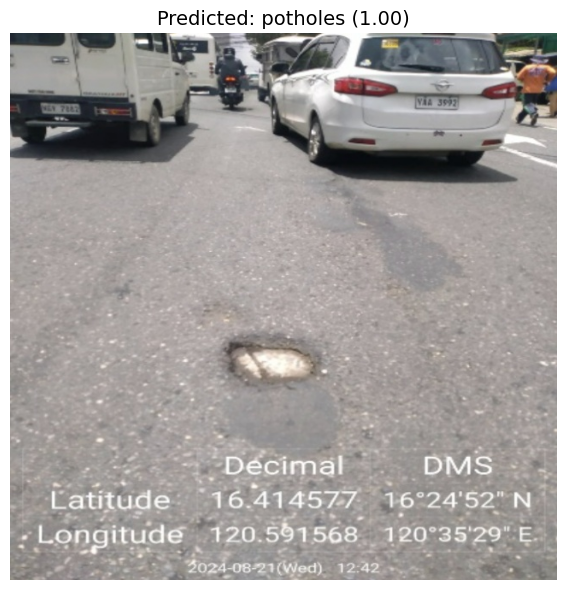

In [3]:
#Slide window testing
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. Load your trained classification model
model = YOLO("best.pt")   # replace with your actual .pt path
model.eval()

# 2. Read & prepare image
img_path = "Road_Damage/train/potholes/images/4 -  Potholes (1).jpg"
bgr = cv2.imread(img_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# 3. Run classification (quietly)
res = model(rgb, imgsz=640, verbose=False)[0]

# 4. Extract top-5 predictions
#    - res.probs.top5: list of top-5 class indices
#    - res.probs.top5conf: list/array of their confidences
top5_idxs  = res.probs.top5
top5_confs = res.probs.top5conf.tolist()

print("Top-5 predictions:")
for idx, conf in zip(top5_idxs, top5_confs):
    label = model.names.get(int(idx), str(idx))
    print(f"  • {label}: {conf:.2f}")

# 5. Display the image with the top-1 label in the title
best_idx, best_conf = top5_idxs[0], top5_confs[0]
best_label = model.names.get(int(best_idx), str(best_idx))

plt.figure(figsize=(8, 6))
plt.imshow(rgb)
plt.title(f"Predicted: {best_label} ({best_conf:.2f})", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
